In [ ]:
import pandas as pd
import spacy 
nlp = spacy.load('en')

In [39]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from collections import Counter 
from bs4 import BeautifulSoup 
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer("english")
stop = set(stopwords.words('english'))

import pickle

def dump(obj,filename):
    filehandler = open(filename,"wb")
    pickle.dump(obj,filehandler)
    filehandler.close()

def load(filename):
    file = open(filename,'rb')
    obj = pickle.load(file)
    file.close()
    return obj

In [82]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### Preprocessing

In [61]:
complaints = pd.read_csv("Consumer_Complaints.csv")

In [62]:
complaints

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,10/01/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/05/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760
5,11/13/2013,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,NaN,U.S. BANCORP,MN,48322,NaN,NaN,Phone,11/20/2013,Closed with monetary relief,Yes,No,596562
6,06/16/2015,Debt collection,Medical,Improper contact or sharing of info,Contacted employer after asked not to,NaN,Company believes it acted appropriately as aut...,California Accounts Service,CA,92111,NaN,Consent not provided,Web,06/19/2015,Closed with explanation,Yes,No,1422680
7,06/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,Company chooses not to provide a public response,Experian Information Solutions Inc.,VA,224XX,NaN,Consent provided,Web,06/15/2015,Closed with explanation,Yes,No,1420702
8,11/13/2015,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,Company believes it acted appropriately as aut...,"Aldridge Pite, LLP",CA,93101,NaN,NaN,Referral,12/10/2015,Closed with explanation,Yes,Yes,1654890
9,10/21/2014,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,OCWEN LOAN SERVICING LLC,FL,32714,Older American,NaN,Web,10/21/2014,Closed with explanation,Yes,No,1079567


In [63]:
complaints = complaints.dropna(subset=['Consumer complaint narrative'])

### Discard the rows where consumer complaint narrative is blank. How many rows does this yield?

In [5]:
complaints.shape

(203728, 18)

#### Function to Clean Text used later

In [106]:
def getCleanText(text, lower = True):
    parse_text = BeautifulSoup(text).get_text()
    
    letters_only = re.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' url ', 
                          parse_text, flags=re.MULTILINE)
    letters_only = re.sub('^(1?[0-9]|2[0-3]):[0-5][0-9]$','time',letters_only)
    letters_only = re.sub('(name|NAME)\d{1,}','username',letters_only)
    
    
    letters_only = re.sub("[^a-zA-Z0-9\.:']",  
                      " ",                   
                      letters_only)
    letters_only = letters_only.replace('\n'," ")
    letters_only = letters_only.replace('\r'," ")
    letters_only = re.sub('[.]{2,}', '. ', letters_only)
    
    
    if lower:
        letters_only = letters_only.lower()
  
    
    
    #words = word_tokenize(lower)
    words = CountVectorizer(stop_words='english').build_tokenizer()(letters_only)
    
    
    meaningful_words = [ w for w in words if len(w)> 0 and len(w)<20]
    
    
    #meaningful_words = [w if (w not in countries) and (w not in cities) else u"country" for w in meaningful_words]
    #lem_words = [wordnet_lemmatizer.lemmatize(w) for w in  meaningful_words]
    #stem_words = [snowball_stemmer.stem(w) for w in lem_words]
    
    
    
    clean_text = " ".join(meaningful_words)

    return clean_text

In [5]:
#define some parameters  
noisy_pos_tags = ['PROP'] # TAGGING OF PROP
min_token_length = 2 # TWO CHARACTERS OR TWO TOKENS?

#Function to check if the token is a noise or not  
def isNoise(token):     
    is_noise = False
    if token.pos_ in noisy_pos_tags: # FROM LIST ABOVE
        is_noise = True 
    elif token.is_stop == True: # FROM STOP WORDS LIST 
        is_noise = True
    elif len(token.string) <= min_token_length: # FROM PARAMETER ABOVE
        is_noise = True
    return is_noise 
def cleanup(token, lower = True):
    if lower: # TURNS ALL TEXT TO LOWERCASE
        token = token.lower()
    return token.strip() # REMOVES SPACES FROM THE BEGINNING AND END

### Named Entity Recognition

In [65]:
def get_entities(sent):
    sentence = unicode(sent.decode('utf8'))
    try:
        document = nlp(sentence)
    except:
        return ["error"]
    
    entities_list = []
    labels = set([w.label_ for w in document.ents]) 
    for label in labels: 
        entities = [cleanup(e.string, lower=False) for e in document.ents if label==e.label_] 
        entities = list(set(entities))
        #Here Labels is ORG if you dont specify this it will give you all entities which we want, 
        #keep the labels as well to explore
        if label == "ORG": 
            entities_list.append(entities)
    if len(entities_list) > 0:
        return entities_list
    else:
        return ["<UNK>"]

org_list = map(get_entities, complaints["Consumer complaint narrative"]) #NAMED entity rowwise

In [136]:
def clean_org(org_list):
    org =  filter(lambda x: "XX" not in x , org_list[0])
    #org = filter(lambda x: "<UNK>" not in x, org)
    return org

clean_org_list = map(clean_org, org_list)

#### Concatentate Named Entities together from all rows

In [69]:
all_orgs = []
for orgs in clean_org_list:
    if orgs == '<UNK>':
        orgs = [orgs]
    all_orgs+=orgs

In [109]:
all_orgs_clean = map(getCleanText, all_orgs)

#### Count of Named Entitites

In [115]:
banks_dict = Counter(all_orgs_clean)
banks_list_sorted = sorted(banks_dict, key = banks_dict.get, reverse=True)
banks_list_sorted_tup = [(bank,banks_dict[bank]) for bank in banks_list_sorted]
banks_list_sorted_tup

[('', 41024),
 (u'equifax', 10101),
 (u'cfpb', 7240),
 (u'wells fargo', 6782),
 (u'bank of america', 6405),
 (u'fcra', 6017),
 (u'chase', 4584),
 (u'navient', 3057),
 (u'fdcpa', 2743),
 (u'transunion', 2734),
 (u'citibank', 2682),
 (u'ftc', 2334),
 (u'capital one', 2218),
 (u'llc', 1931),
 (u'irs', 1702),
 (u'ocwen', 1638),
 (u'american express', 1609),
 (u'experian', 1563),
 (u'the fair credit reporting act', 1439),
 (u'chase bank', 1311),
 (u'us bank', 1283),
 (u'fha', 1281),
 (u'social security', 1208),
 (u'boa', 1202),
 (u'bank', 1176),
 (u'citi', 1165),
 (u'nationstar', 1158),
 (u'pnc', 1064),
 (u'hud', 1025),
 (u'usc', 1020),
 (u'cra', 1016),
 (u'va', 987),
 (u'usps', 964),
 (u'synchrony bank', 887),
 (u'hamp', 864),
 (u'usaa', 860),
 (u'amex', 848),
 (u'trans union', 796),
 (u'wells fargo bank', 796),
 (u'the fair debt collection practices act', 793),
 (u'the federal trade commission', 765),
 (u'ssn', 752),
 (u'macy', 735),
 (u'the consumer financial protection bureau', 704),
 (

In [79]:
dump(banks_list_sorted_tup, "bank_counts.pkl")

In [116]:
banks = map(lambda x:x[0] , banks_list_sorted_tup)
banks_count = map(lambda x: x[1], banks_list_sorted_tup)

In [137]:
banks_count_df = pd.DataFrame(data = banks_list_sorted_tup)
banks_count_df.columns = ["Bank_Name", "Count"]

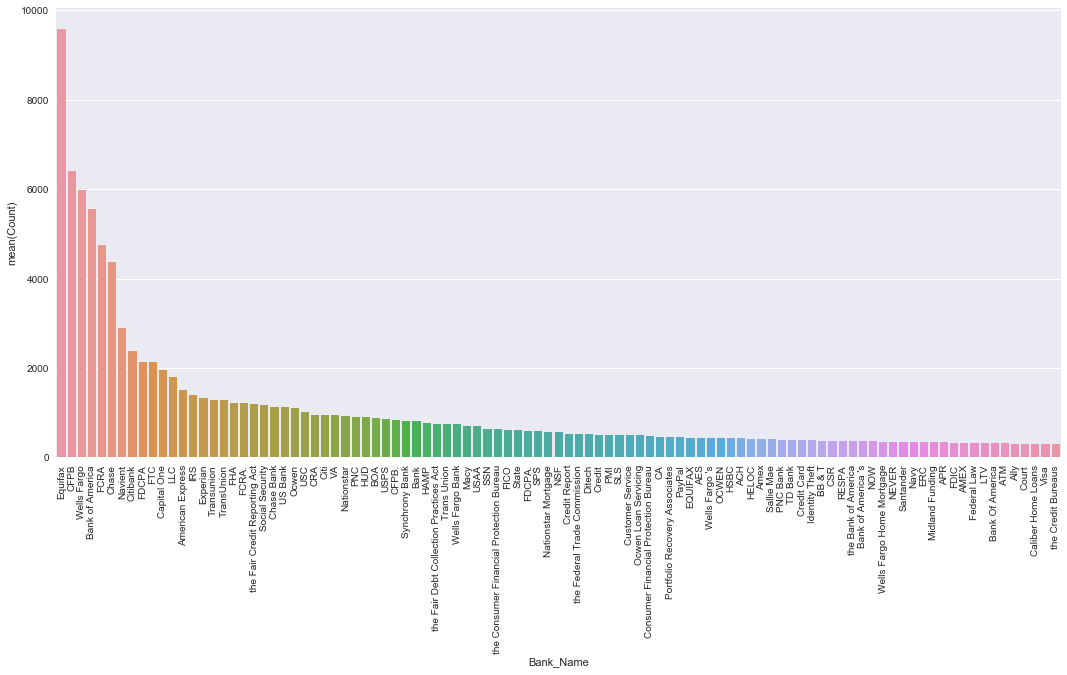

In [103]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(18, 8.27)
ax = sns.barplot(x="Bank_Name", y="Count", data = banks_count_df[1:100])
_ = plt.xticks(rotation=90)

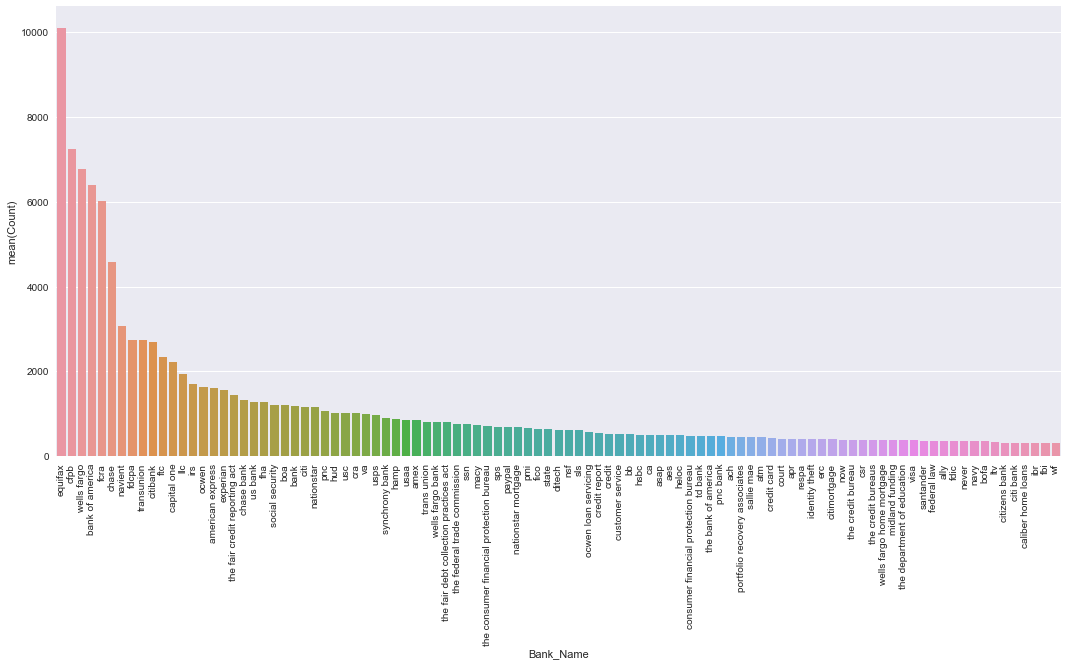

In [118]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(18, 8.27)
ax = sns.barplot(x="Bank_Name", y="Count", data = banks_count_df[1:100])
_ = plt.xticks(rotation=90)